# Model report 

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import keras
from keras.models import load_model
import keras.backend as K

from sincnet import SincConv1D
from normal_models import get_model

from train_normal import DataGenerator, print_cm
import sklearn.metrics
import shap
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!
         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


In [2]:
def load_data():
    g = DataGenerator()
    X, y = g.data()
    train_set, valid_set, test_set = g.split(X, y)
    
    # do normalize using means and stds from training data
    train_set[0], means_and_stds = DataGenerator.normalize(train_set[0])
    valid_set[0], _ = DataGenerator.normalize(valid_set[0], means_and_stds)
    test_set[0], _ = DataGenerator.normalize(test_set[0], means_and_stds)
    
    return train_set, valid_set, test_set

WHOLE_DATASET = load_data()

baseline: 0.8921465968586387


In [3]:
MODEL_CACHE = None
MODEL_CACHE_NAME = None

In [65]:
import numpy as np
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

In [91]:
def get_report(model_path, set_name='test', positive=False):
    def print_basic_report():
        y_pred = np.argmax(model.predict(dataset_X, batch_size=dataset_X.shape[0]), axis=1)
        y_true = dataset_y[:, 1]

        print(sklearn.metrics.classification_report(y_true, y_pred))
        print_cm(sklearn.metrics.confusion_matrix(y_true, y_pred), ['normal', 'patient'])
        
    def plot(signal, original=None, do_filter=True):
        n_channel = signal.shape[-1]
        fig, axes = plt.subplots(n_channel, 1, figsize=(30, 2*n_channel), sharex=True)
        fig.tight_layout()
        
        signal_min, signal_max = np.Inf, -np.Inf
        for i_channel, ax in enumerate(axes):
            s = butter_lowpass_filter(signal[..., i_channel], 10, 1000) if do_filter else signal[..., i_channel]
            signal_min, signal_max = min(signal_min, s.min()), max(signal_max, s.max())
            
            ax.plot(s, color='g')
            ax.plot(np.zeros_like(signal[..., i_channel]), color='r')
            if original is not None:
                ax.twinx().plot(original[..., i_channel], alpha=0.3, color='b')
        
        for ax in axes: ax.set_ylim(signal_min, signal_max)
        plt.margins(x=0, y=0)
        plt.show()
    
    # get data instance
    dataset_X, dataset_y = WHOLE_DATASET[{'train':0, 'valid':1, 'test':2}[set_name]]
    
    # get one sample
    sample_index = np.random.choice( np.where(dataset_y[:, 1] == positive)[0], size=1)
    sample_X, sample_y = dataset_X[sample_index], dataset_y[sample_index]
    # sample_X, sample_y = sample_X[np.newaxis, ...], sample_y[np.newaxis, ...]
    
    # load model
    # do cache thing
    print('Loading model', model_path)
    
    global MODEL_CACHE
    global MODEL_CACHE_NAME
    if MODEL_CACHE_NAME == model_path:
        print('Using model cache!')
        model = MODEL_CACHE
    else:
        K.clear_session()
        model = load_model(model_path, custom_objects={'SincConv1D': SincConv1D}, compile=False)
        # update cache
        MODEL_CACHE = model
        MODEL_CACHE_NAME = model_path
        
    model.summary()
    
    # start analysis
    print('Report for', model_path)
    
    # get basic report
    print_basic_report()
    
    # plot original signal
    # plot(sample_X[0, :, :][:, [0, -2, -1]])
    
    # shap visualization
    print('\n==============================================================\n')
    print('From Set:', set_name, 'set')
    print('Sample id:', sample_index[0])
    print('Sample is', 'abnormal' if positive else 'normal')
    print('Predict abnormal chance:', model.predict(sample_X)[0][1])
    e = shap.DeepExplainer(model, WHOLE_DATASET[0][0])
    
    shap_values = e.shap_values(sample_X)
    
    plot(shap_values[0][0, ...], sample_X[0, :, :])

Loading model ./model_checkpoints/working_200_0.29/200-0.29.h5
Using model cache!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 10)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10000, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
___________________________

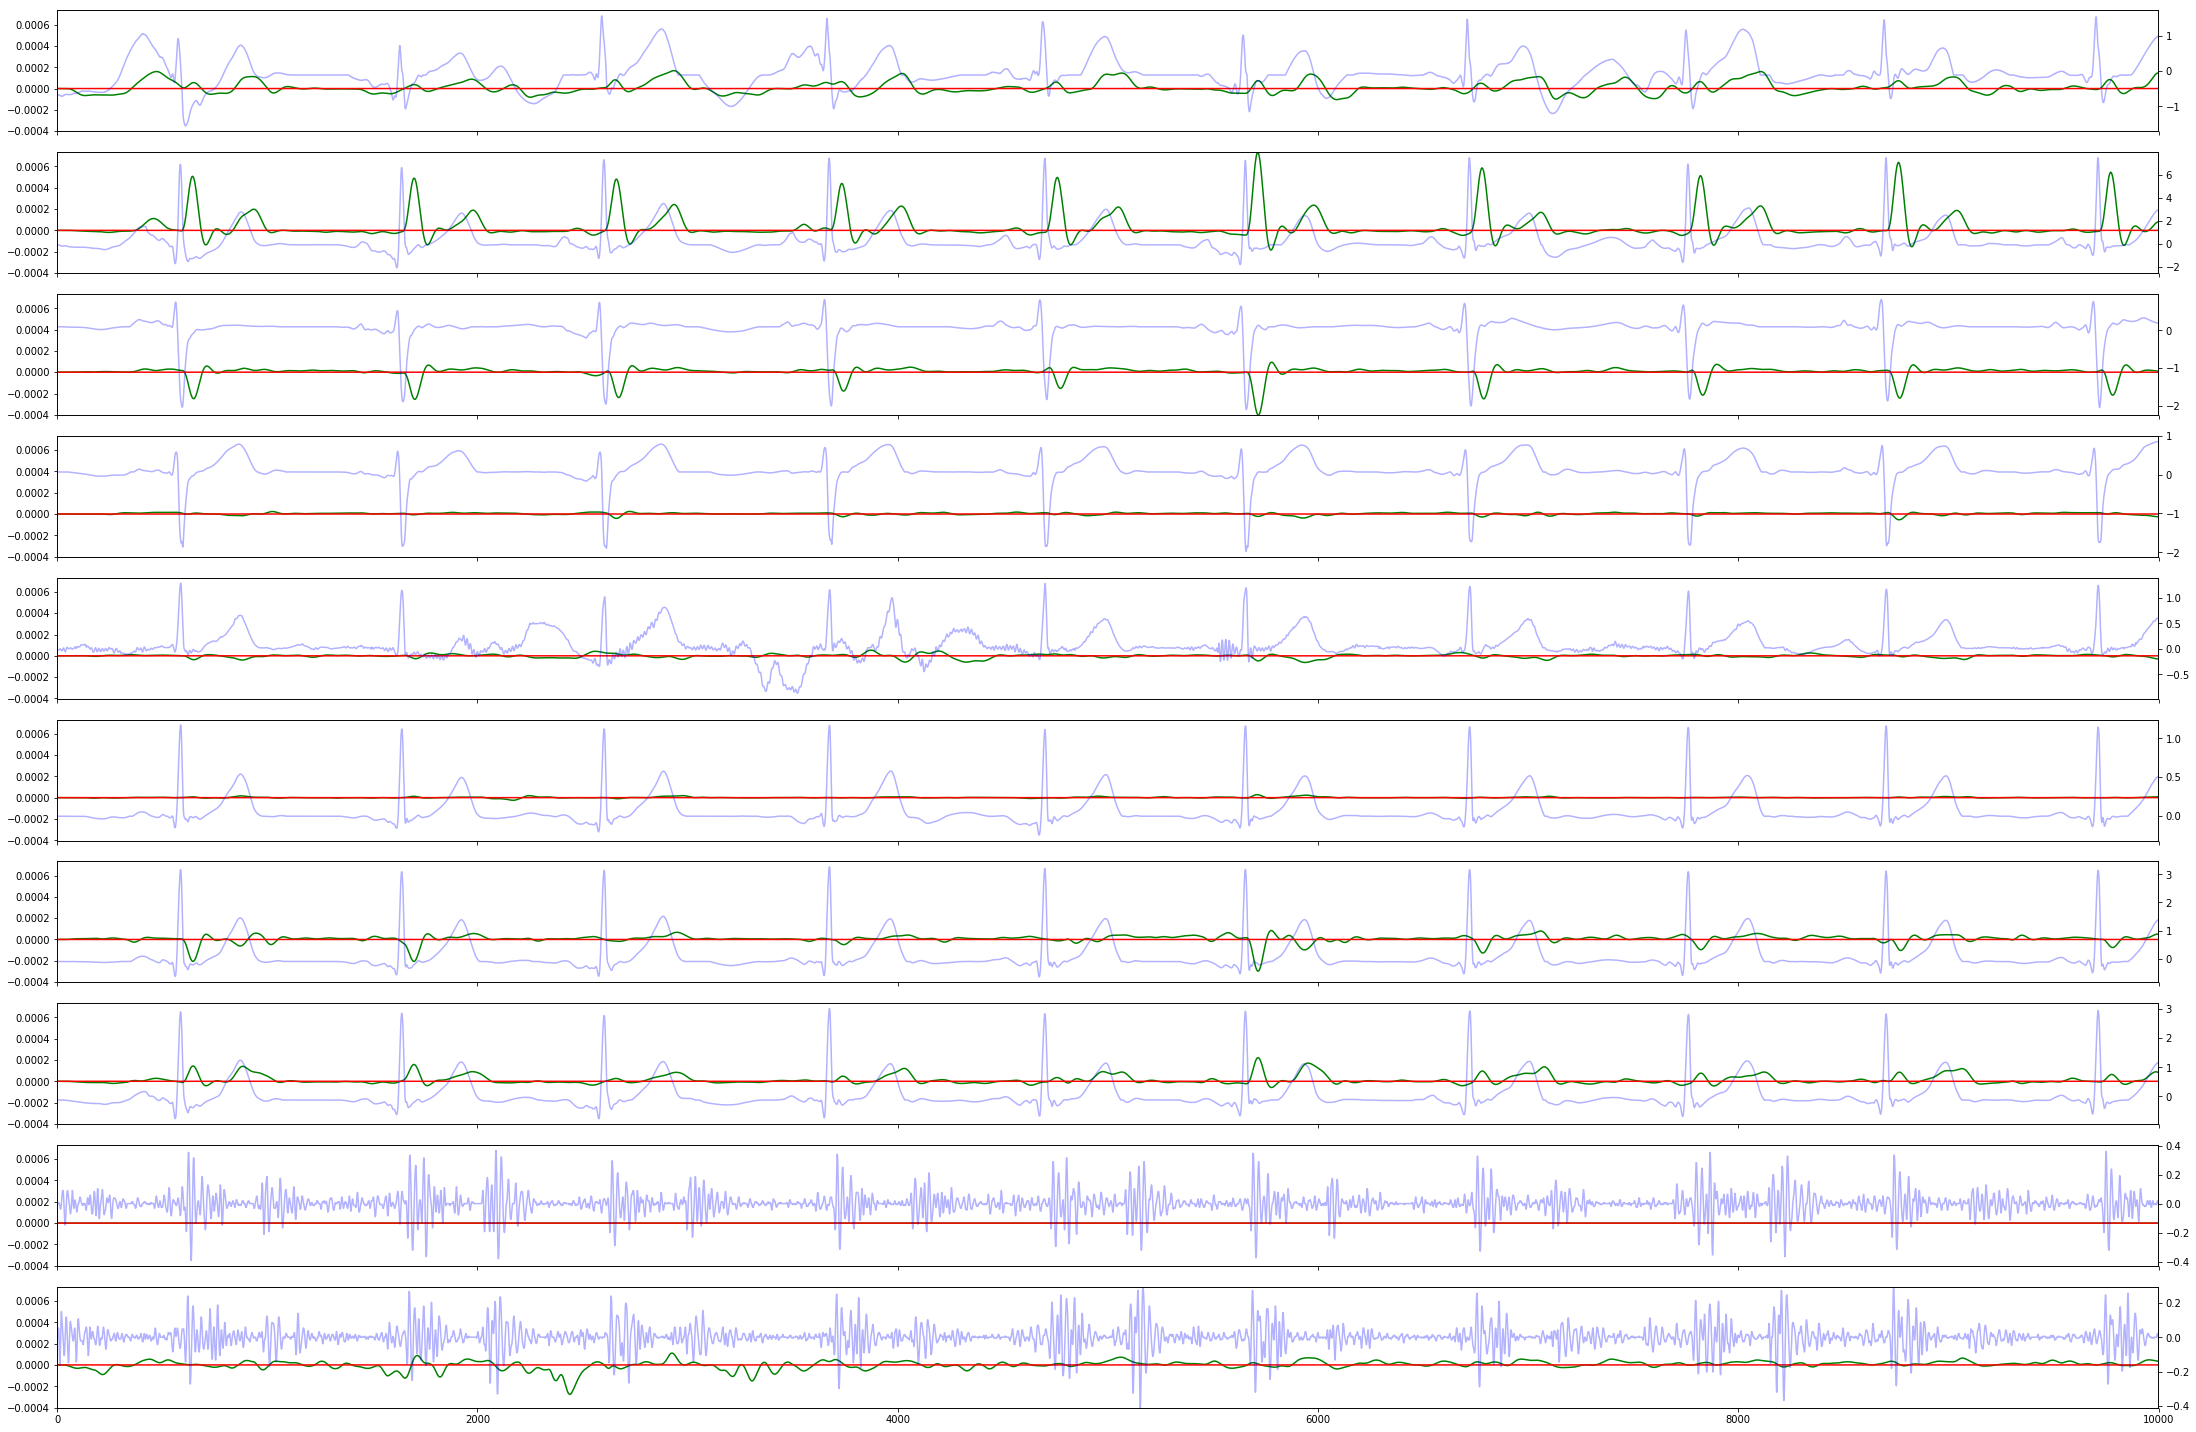

In [92]:
get_report('./model_checkpoints/working_200_0.29/200-0.29.h5', 'test', positive=False)

Loading model ./model_checkpoints/working_200_0.29/200-0.29.h5
Using model cache!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 10)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10000, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
___________________________

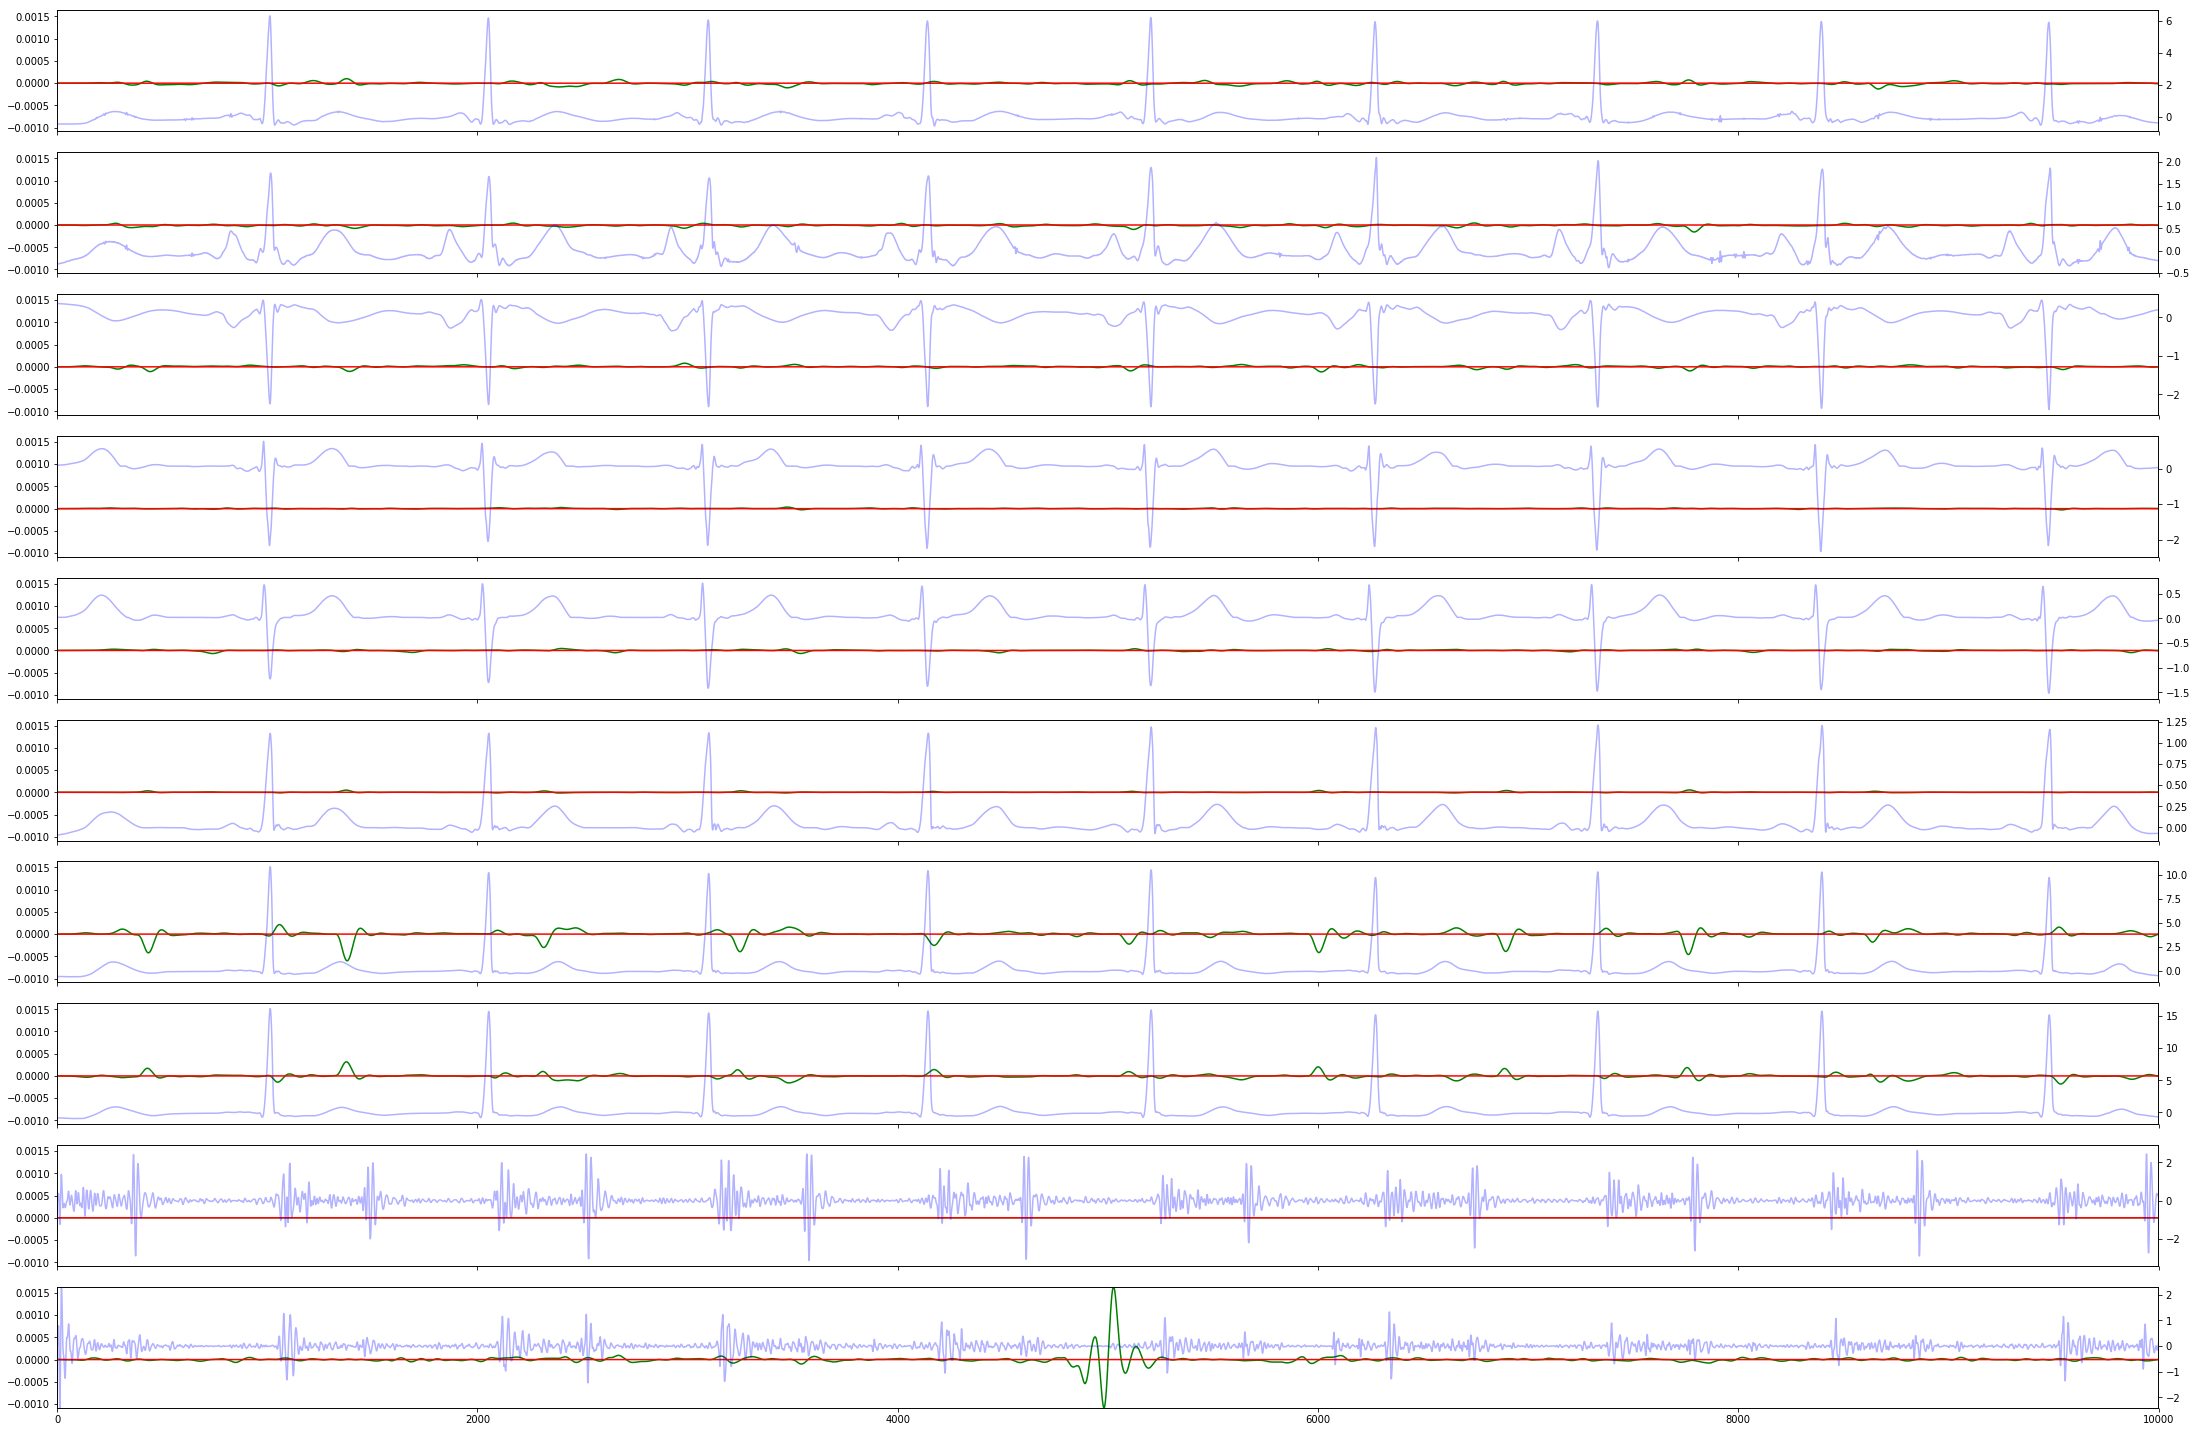

In [94]:
get_report('./model_checkpoints/working_200_0.29/200-0.29.h5', 'test', positive=True)

Loading model ./model_checkpoints/working_200_0.29/200-0.29.h5
Using model cache!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 10)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10000, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
___________________________

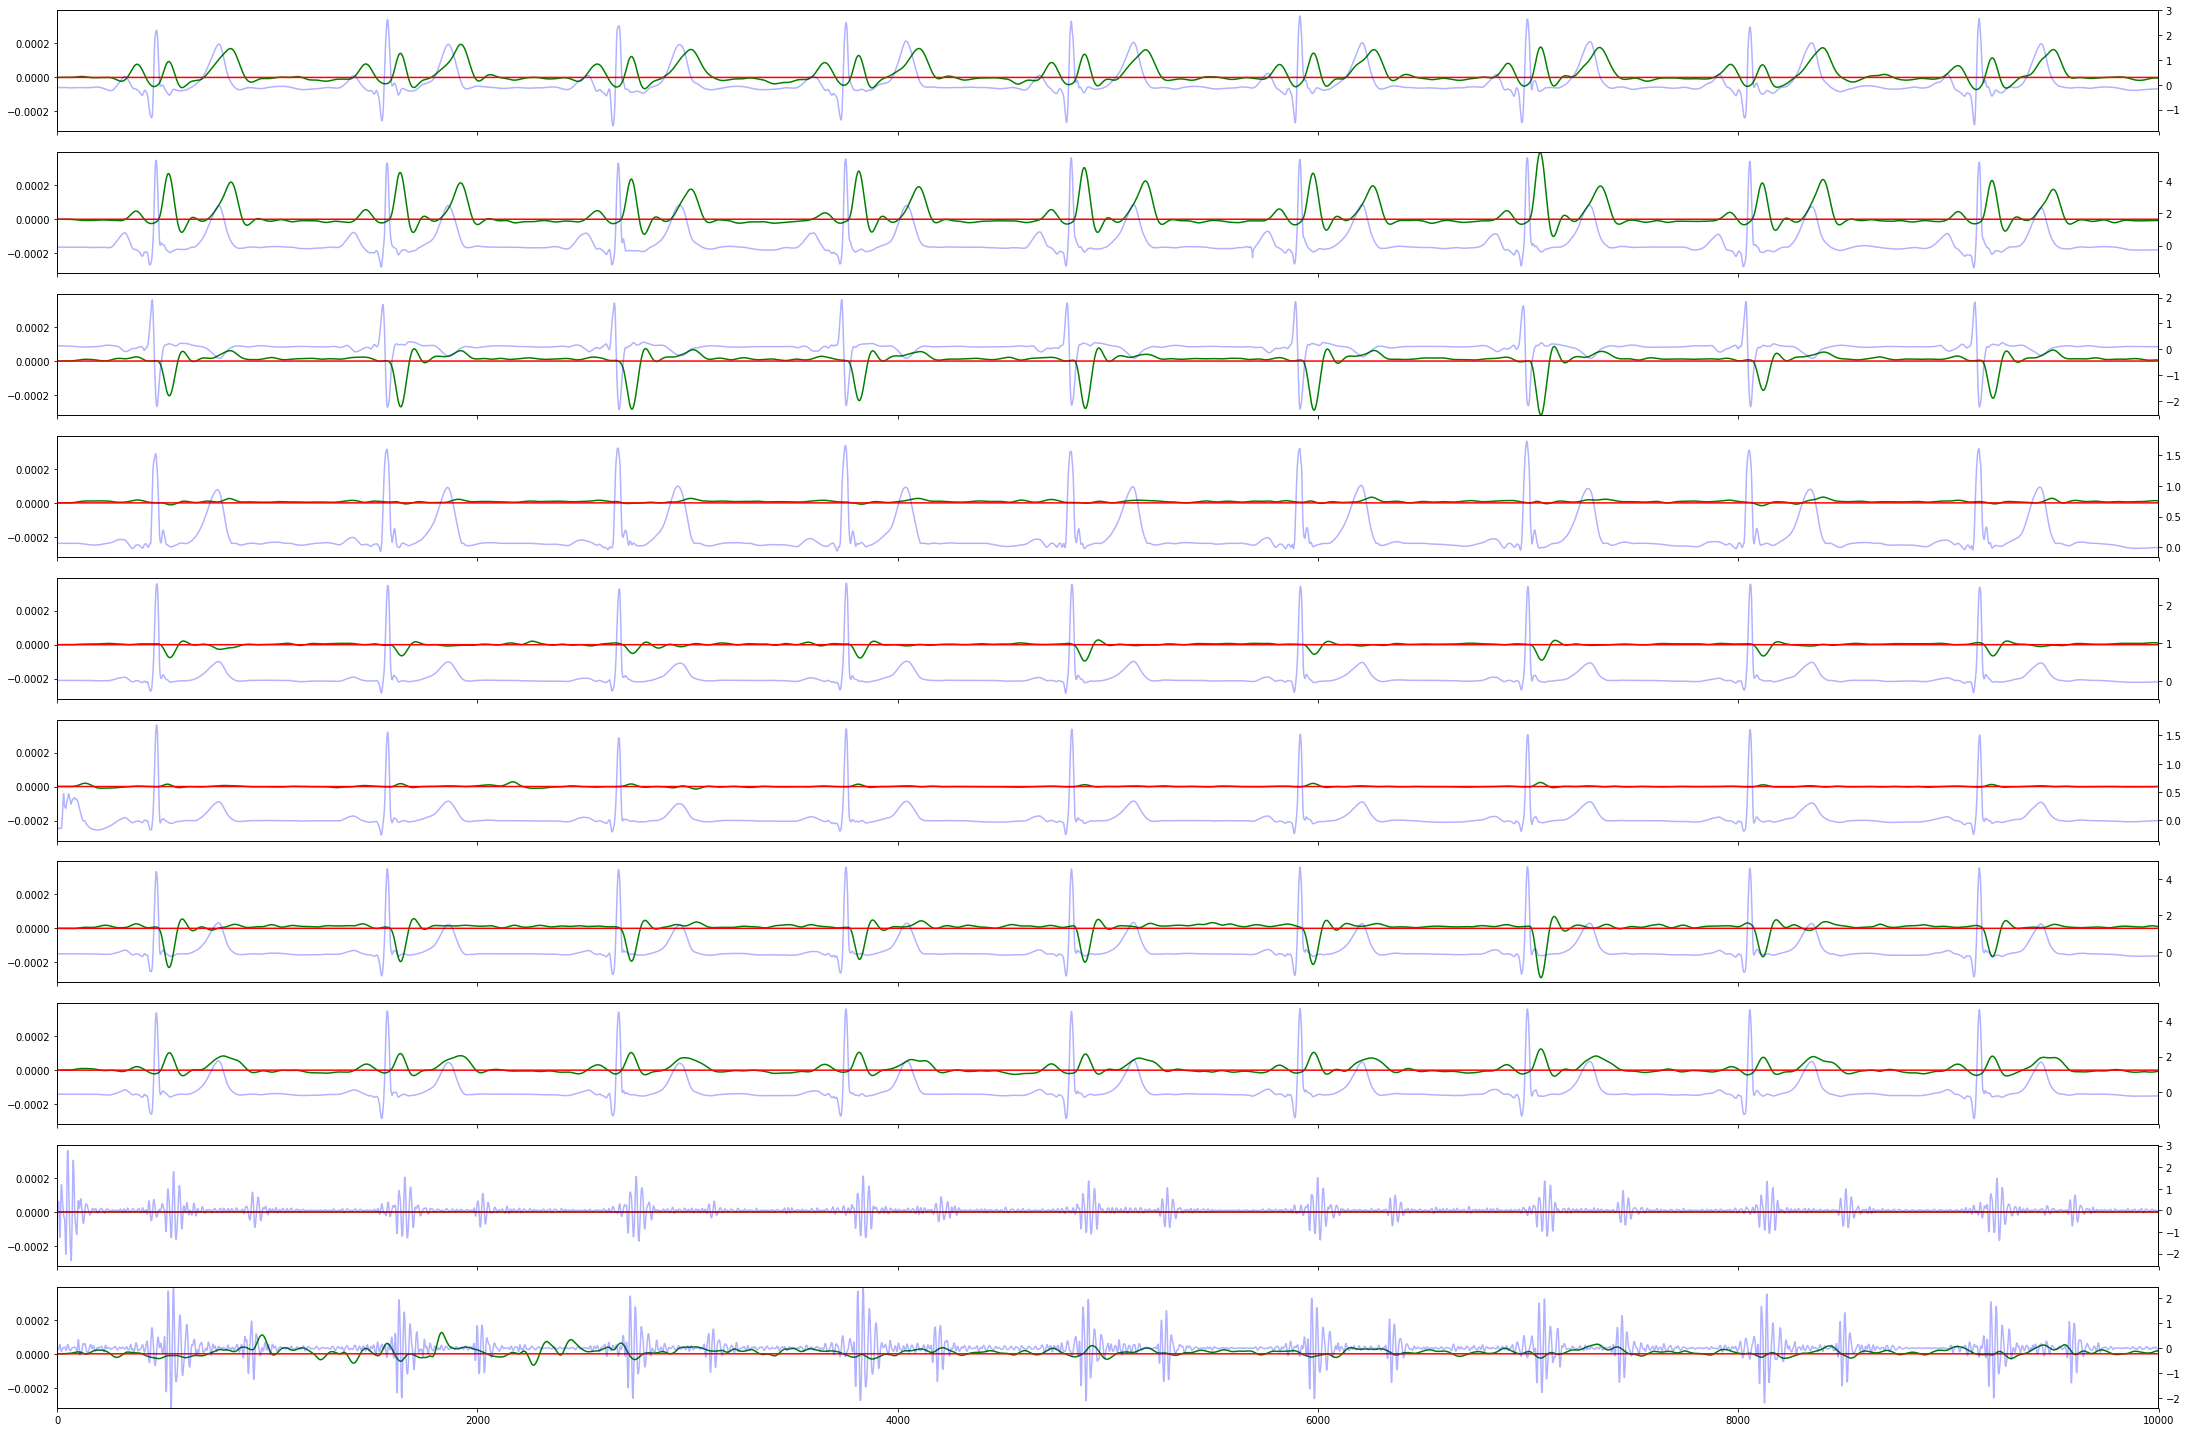

In [93]:
get_report('./model_checkpoints/working_200_0.29/200-0.29.h5', 'test', positive=True)

Loading model ./model_checkpoints/20190220220041/200-0.32.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 10)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10000, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
________________________________________________

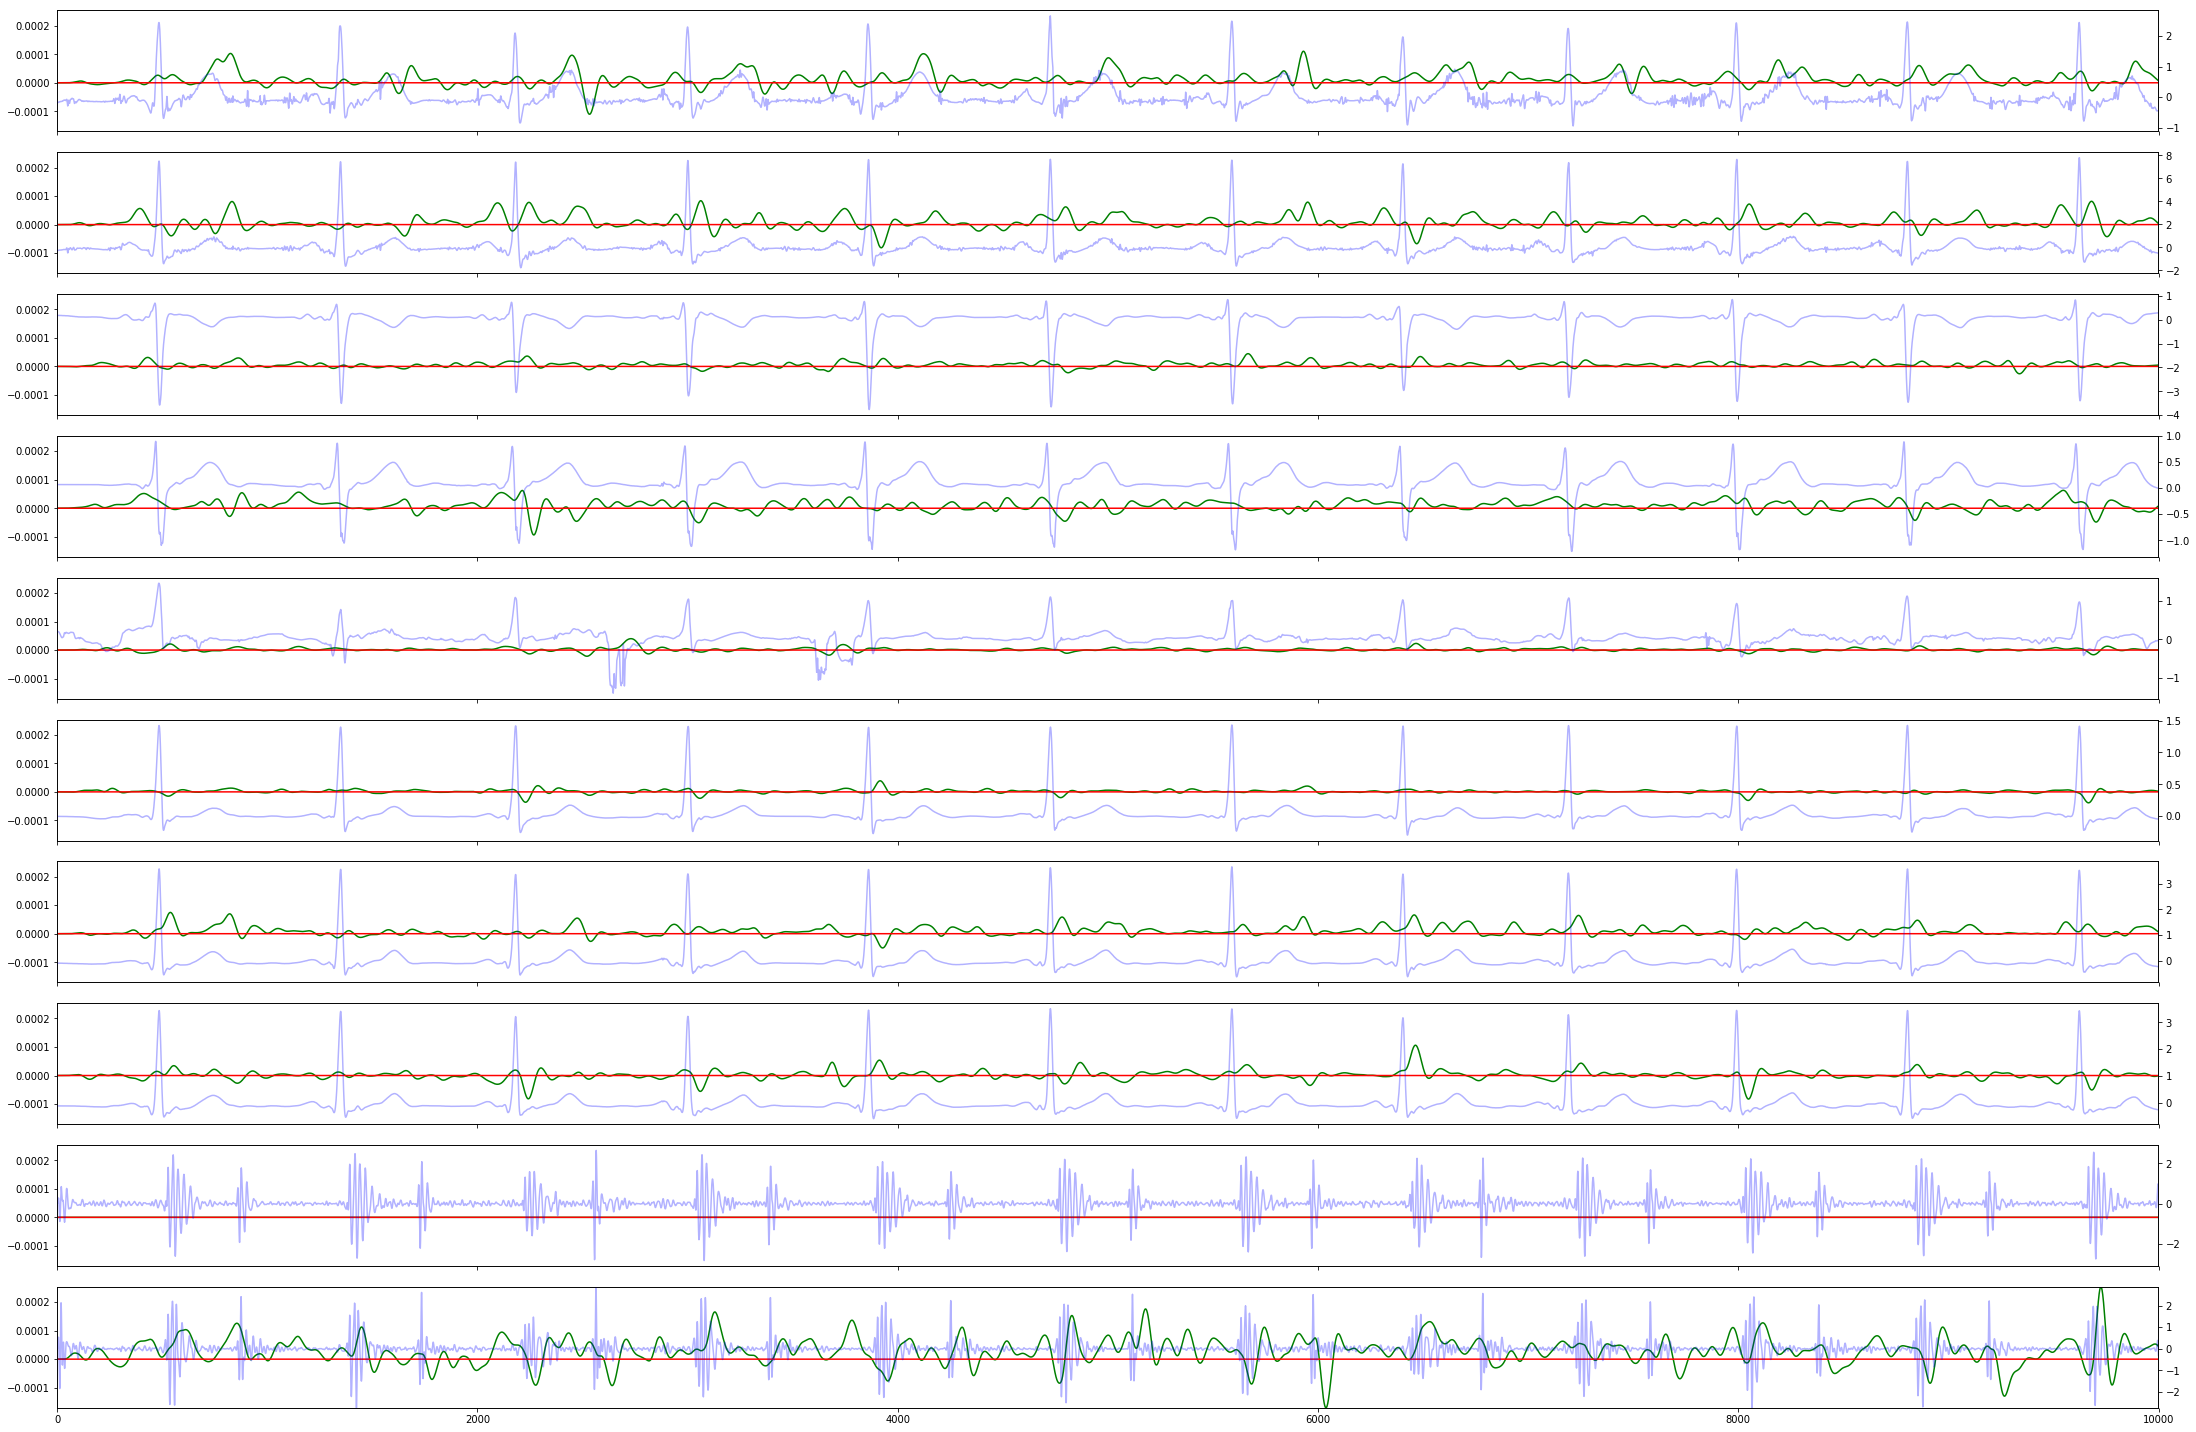

In [95]:
get_report('./model_checkpoints/20190220220041/200-0.32.h5', 'test', positive=False)

Loading model ./model_checkpoints/20190220220041/200-0.32.h5
Using model cache!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 10)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10000, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
_____________________________

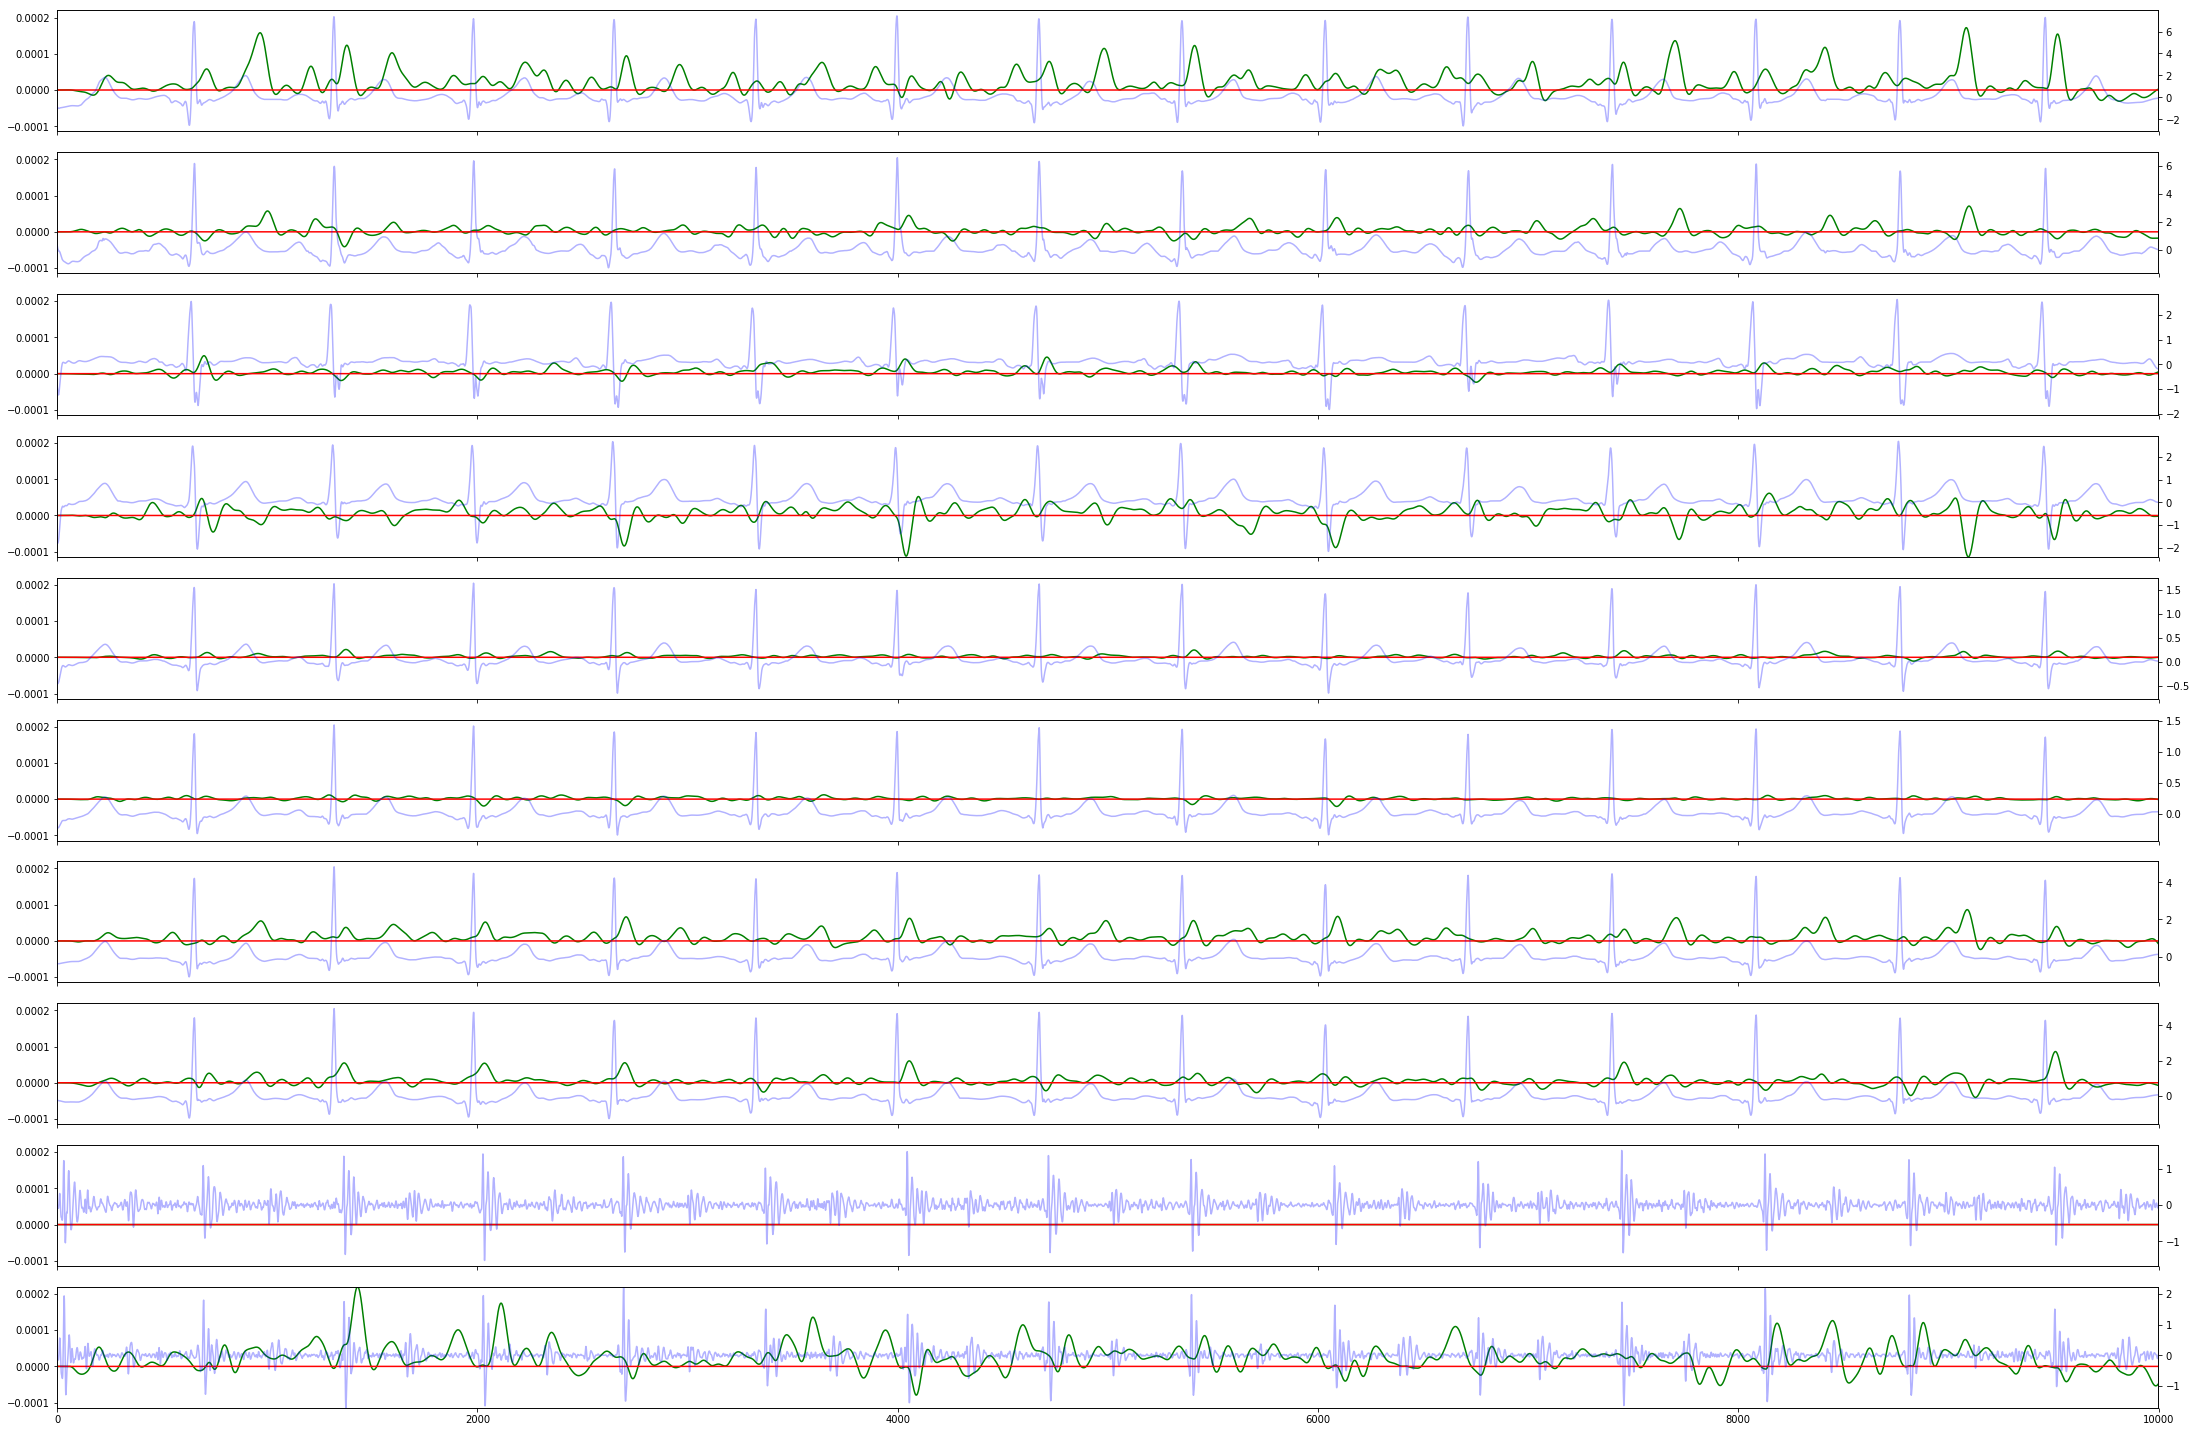

In [96]:
get_report('./model_checkpoints/20190220220041/200-0.32.h5', 'test', positive=True)

Loading model ./model_checkpoints/20190220220041/200-0.32.h5
Using model cache!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 10)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10000, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 10000, 1)     0           lambda_2[0][0]                   
_____________________________

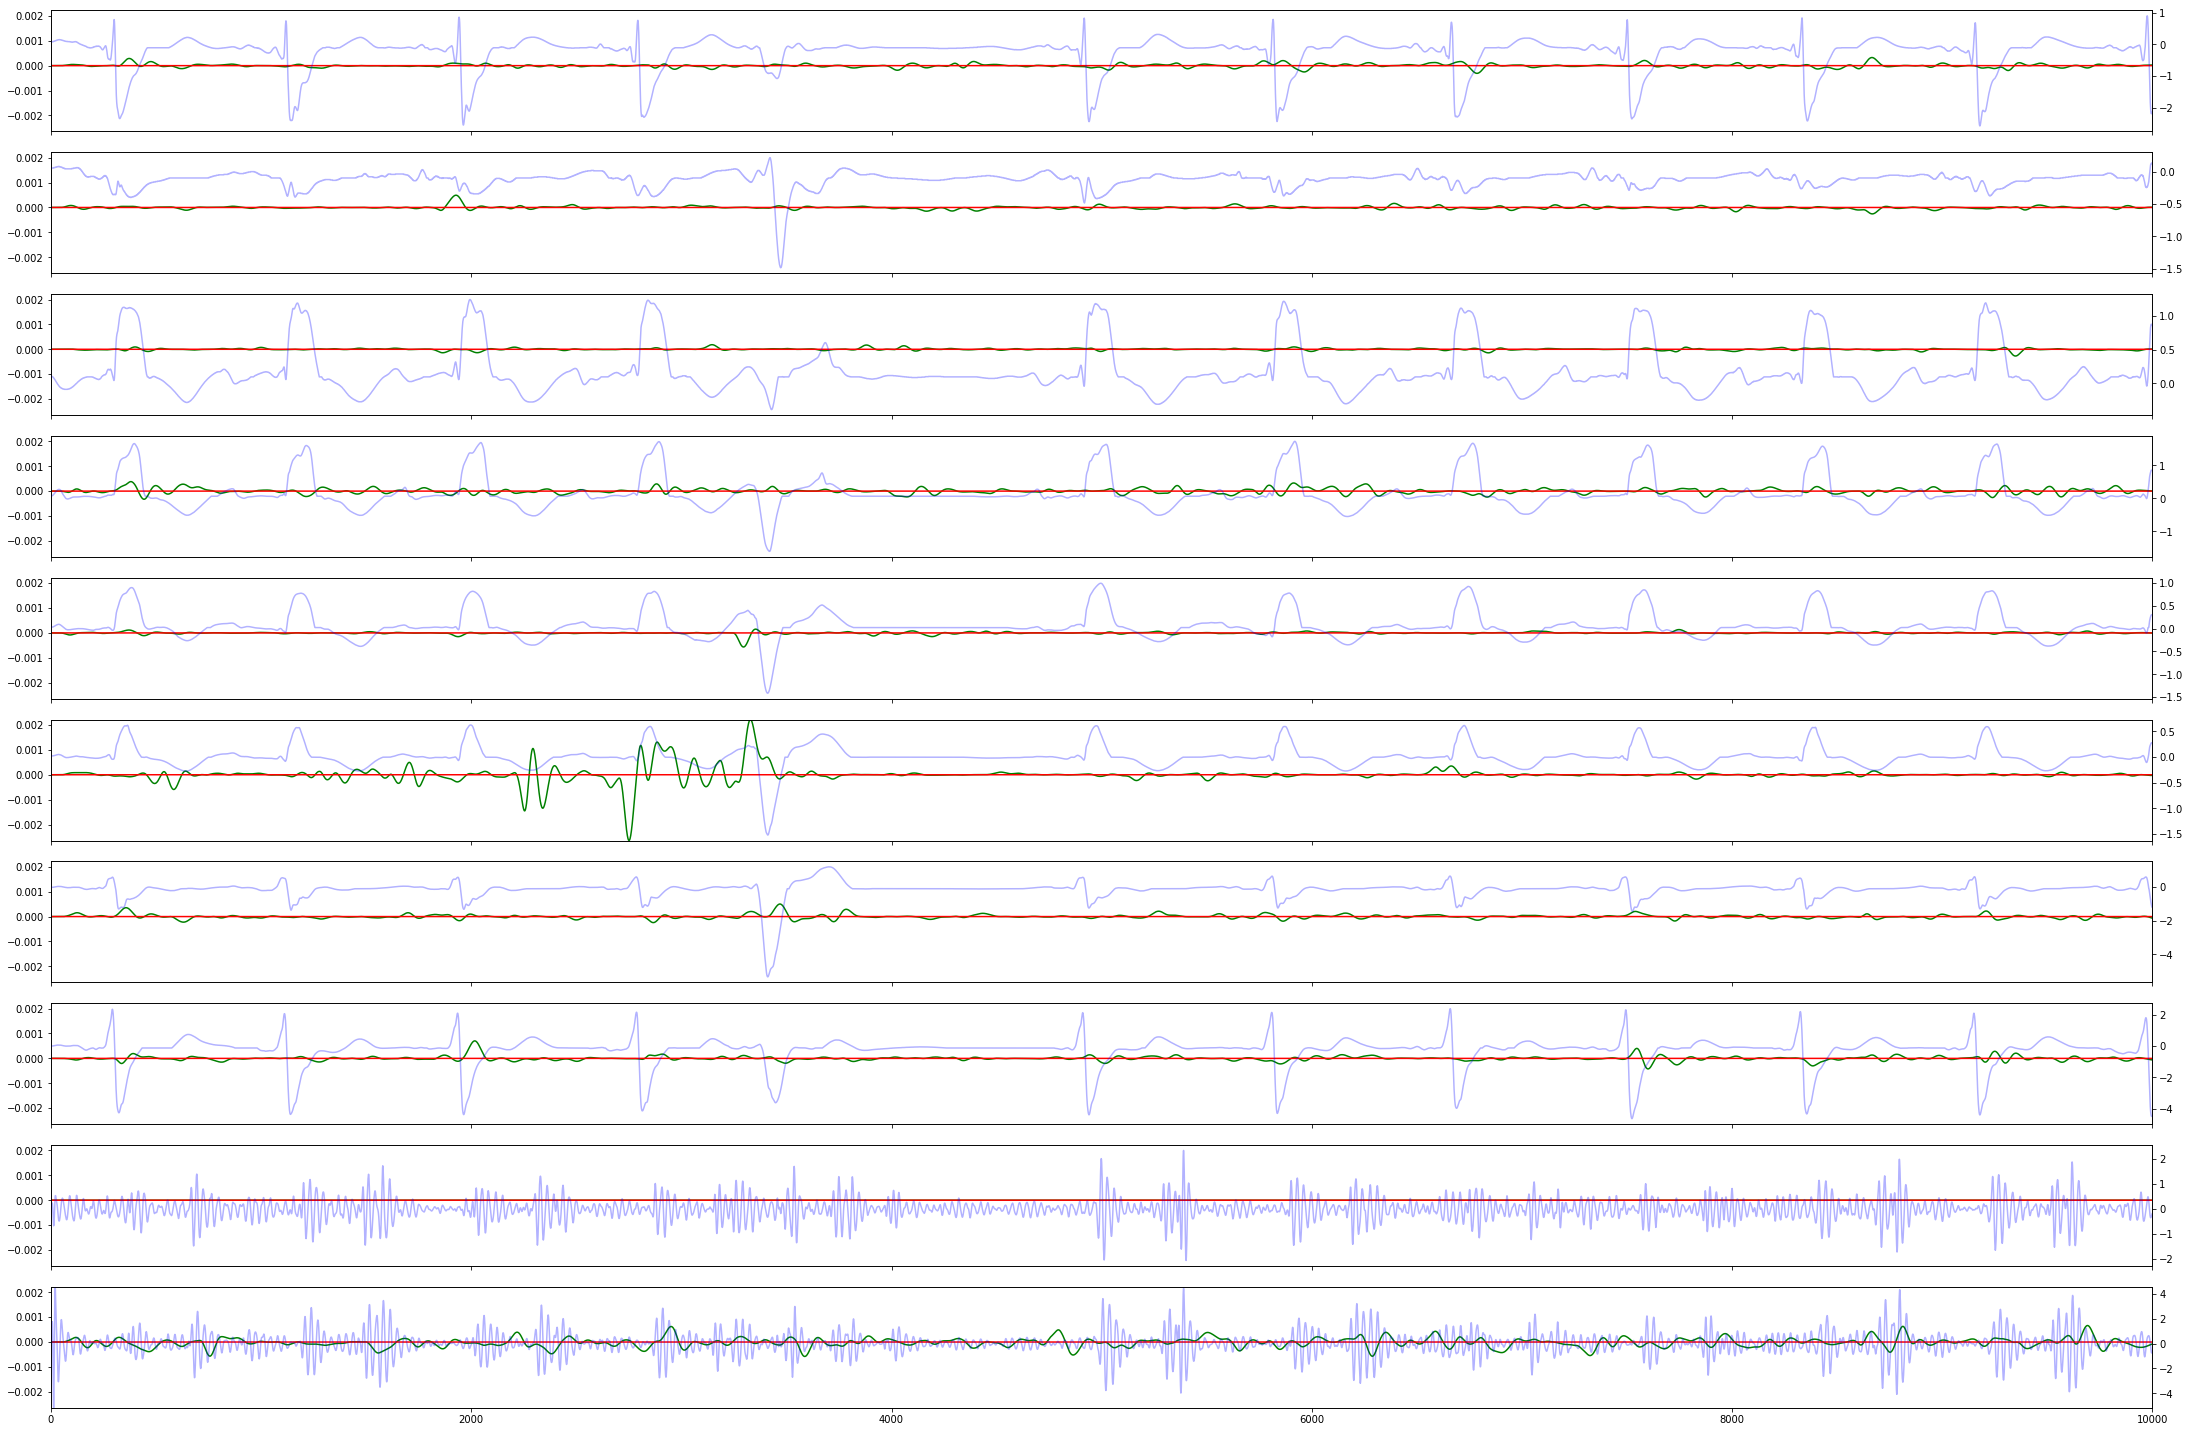

In [97]:
get_report('./model_checkpoints/20190220220041/200-0.32.h5', 'test', positive=True)

In [ ]:
model = load_model('./model_checkpoints/20190220000052/100-0.15.h5', custom_objects={'SincConv1D': SincConv1D})

In [ ]:
g = DataGenerator()
X, y = g.data()
train_set, valid_set, test_set = split(X, y)

In [ ]:
# do normalize using means and stds from training data
train_set[0], means_and_stds = DataGenerator.normalize(train_set[0])
valid_set[0], _ = DataGenerator.normalize(valid_set[0], means_and_stds)
test_set[0], _ = DataGenerator.normalize(test_set[0], means_and_stds)

In [ ]:
print(means_and_stds)
print(test_set[0].dtype)
print(test_set[0].mean())
print(test_set[1].shape)

In [ ]:
for i in range(test_set[1].shape[0]):
    if test_set[1][i, 0] == 1:
        print(i)

In [ ]:
model.predict(test_set[0][30:31])

In [ ]:
from keract import get_activations
acts = get_activations(model, test_set[0][30:31])

In [ ]:
model.summary()

In [ ]:
print(acts.keys())

In [ ]:
print(np.array(acts['sinc_conv1d_1/convolution/Squeeze:0']).shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30, 4))
plt.plot(test_set[0][30][:, 8])
plt.show()

plt.figure(figsize=(30, 4))
plt.plot(np.array(acts['re_lu_1/Relu:0'])[0, :, 0])
plt.show()

# conv1d_3/Relu:0

plt.figure(figsize=(30, 4))
plt.plot(np.array(acts['conv1d_4/Relu:0'])[0, :, 5])
plt.show()

# add_1/add:0

plt.figure(figsize=(30, 4))
plt.plot(np.array(acts['add_1/add:0'])[0, :, 7])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30, 4))
plt.plot(test_set[0][30][:, 0])
plt.show()

plt.figure(figsize=(30, 4))
plt.plot(np.array(acts['conv1d_1/Relu:0'])[0, :, 2])
plt.show()

# conv1d_3/Relu:0

plt.figure(figsize=(30, 4))
plt.plot(np.array(acts['conv1d_2/Relu:0'])[0, :, 1])
plt.show()

plt.figure(figsize=(30, 4))
plt.plot(np.array(acts['conv1d_6/Relu:0'])[0, :, 0])
plt.show()